# <MNIST 분석하기 CNN 활용>

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

C:\Users\S340\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### 1.MNIST에서 데이터 받기

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

W0922 20:00:56.166897 12668 deprecation.py:323] From <ipython-input-2-a839aeb82f4b>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0922 20:00:56.168944 12668 deprecation.py:323] From C:\Users\S340\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0922 20:00:56.170938 12668 deprecation.py:323] From C:\Users\S340\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please u

Extracting MNIST_data/train-images-idx3-ubyte.gz


W0922 20:00:56.674437 12668 deprecation.py:323] From C:\Users\S340\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0922 20:00:56.681621 12668 deprecation.py:323] From C:\Users\S340\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0922 20:00:56.772369 12668 deprecation.py:323] From C:\Users\S340\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version

Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#파라미터 초기화
learning_rate = 0.001
training_epochs = 15
batch_size = 100

### 2.신경망 모델 정의

In [4]:
class Model:
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            self.training = tf.placeholder(tf.bool)

            # X, Y 정의
            self.X = tf.placeholder(tf.float32, [None, 784])
            self.Y = tf.placeholder(tf.float32, [None, 10])
            
            # 이미지 형태 : 28x28x1 (black/white), 입력층 
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])


            # Layer1 : Convolutional Layer & Pooling Layer
            conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)

            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1,
                                         rate=0.3, training=self.training)

            # Layer2 : Convolutional Layer & Pooling Layer
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2,
                                         rate=0.3, training=self.training)

            # Layer3 : Convolutional Layer & Pooling Layer
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3],
                                     padding="same", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                                            padding="same", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3,
                                         rate=0.3, training=self.training)

            # Last Layer
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs=flat,
                                     units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4,
                                         rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=10)

        # cost/loss & optimizer 정의
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # 예측 값 확인: False, true
    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,
                             feed_dict={self.X: x_test, self.training: training})
    
    # 정답률 확인
    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,
                             feed_dict={self.X: x_test,
                                        self.Y: y_test, self.training: training})
    # Train 정의
    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.training: training})


In [5]:
# 세션 Initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

W0922 20:00:57.257315 12668 deprecation.py:323] From <ipython-input-4-31cc24d7ea1d>:23: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0922 20:00:57.262495 12668 deprecation.py:506] From C:\Users\S340\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0922 20:00:57.486709 12668 deprecation.py:323] From <ipython-input-4-31cc24d7ea1d>:26: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0922 20:00:57.687880 12668 deprecation.py:323] From <ipython-input-4-31cc24d7ea1d>:28

### 2. 모델 학습 시키기

In [6]:
print('Learning Started!')

# 모델 Train
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        c, _ = m1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning Started!
Epoch: 0001 cost = 0.286021375
Epoch: 0002 cost = 0.087758843
Epoch: 0003 cost = 0.064969804
Epoch: 0004 cost = 0.054139133
Epoch: 0005 cost = 0.049976177
Epoch: 0006 cost = 0.044085789
Epoch: 0007 cost = 0.040693895
Epoch: 0008 cost = 0.037570163
Epoch: 0009 cost = 0.036888461
Epoch: 0010 cost = 0.034093232
Epoch: 0011 cost = 0.030709183
Epoch: 0012 cost = 0.030616447
Epoch: 0013 cost = 0.029343890
Epoch: 0014 cost = 0.027865206
Epoch: 0015 cost = 0.026576360
Learning Finished!


In [7]:
# Train 모델 정답률 확인
print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))

Accuracy: 0.9927


### 3. 임의값 테스트 결과 확인

Label:  [6]
Prediction:  [6]


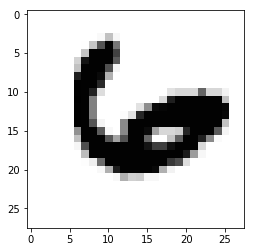

In [8]:
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(m1.logits, 1), feed_dict={m1.X: mnist.test.images[r:r + 1], m1.training:False}))

plt.imshow(mnist.test.images[r:r + 1].
          reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()
